In [1]:
from skimage import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from Models import U_net3D
import sklearn


c:\ProgramData\Anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
a = np.zeros([2,100])
a[0, 2] = 1
a[1,0:10] = 1

weights = []
all_ones = np.sum(a == 1)
for c in range(a.shape[0]):
    v = a[c]
    ones_a = all_ones / np.sum(v==1) 
    weights.append(ones_a)

print(weights)



[11.0, 1.1]


In [13]:
# %load Models/U_net
from Models import BaseModel
import torch
import torchvision
from torch import nn
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pytorch_lightning.callbacks import Callback

class Encoder(torch.nn.Module):
    def __init__(self, c_in, c_out, ksize, MPS):
        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(c_in, c_out, ksize, stride = 1, padding=ksize // 2+1),
            nn.LeakyReLU()
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(c_out, c_out, ksize, stride = 1, padding=ksize // 2+1),
            nn.LeakyReLU(),
         )
        self.pool = nn.MaxPool2d(MPS)
        self.BN = nn.BatchNorm2d(c_out)


    def forward(self, x):
        y = self.conv_1(x); 
        y = self.conv_2(y); 
        y = self.pool(y);
        y = self.BN(y)
        return y

class Decoder(torch.nn.Module):

    def __init__(self, c_in, c_out, ksize, MPS):
        super().__init__()
        self.MPS = MPS
        self.upconv_1 = nn.Sequential(
            nn.ConvTranspose2d(c_in, c_out, ksize, stride = 1, padding=ksize // 2+1),
            nn.LeakyReLU()
        )
        self.upconv_2 = nn.Sequential(
            nn.ConvTranspose2d(c_out, c_out, ksize, stride = 1, padding=ksize // 2+1),
            nn.LeakyReLU(),
        )
        self.BN = nn.BatchNorm2d(c_out)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.MPS, mode='bilinear')
        y = self.upconv_1(x);   
        y = self.upconv_2(y);   
        y = self.BN(y)
        return y

class U_net(BaseModel):

    def __init__(self, img_size, learning_rate):
        super().__init__(img_size, learning_rate)
        MPS = 2
        self.CN = 3
        self.enc_1 = Encoder(1, 9, 3, MPS)
        self.enc_2 = Encoder(9, 18, 3, MPS)
        self.enc_3 = Encoder(18, 36, 3, MPS)

        self.dec_3 = Decoder(36, 18, 3, MPS)
        self.dec_2 = Decoder(18, 9, 3, MPS)
        self.dec_1 = Decoder(9, self.CN, 3, MPS)

        self.output_function = nn.Softmax(dim=1)
        self.save_hyperparameters()
        self.example_input_array = torch.rand([1,1,img_size[0],img_size[1]])

    def compute_class_weights(self, x):
        weights = []
        all_ones = torch.sum(x == 1)
        for c in range(self.CN):
            ones_a = all_ones / torch.sum(x[:,c]==1) 
            weights.append(ones_a)
        return torch.tensor(weights).float().cuda()

    def loss(self, output, target):

        # The best so far
        loss = 0
        # for c in range(self.CN):
        #     o = output[:,c]
        #     t = target[:,c]
        #     loss_1 = torch.mean(torch.square(o[t == 0] - t[t == 0]))
        #     loss_2 = torch.mean(torch.square(o[t == 1] - t[t == 1]))
        #     loss += loss_1 + loss_2

        t = target
        o = output
        weights = self.compute_class_weights(t)
        loss = torch.nn.CrossEntropyLoss(weight=weights)(o,t)


        # zeros = torch.sum(target == 0)
        # ones  = torch.sum(target == 1)

        # relative_frequency_0 = zeros / (zeros + ones)
        # relative_frequency_1 = ones  / (zeros + ones)
        # BG = (output[target == 0] - target[target == 0])
        # FG = (output[target == 1] - target[target == 1])
        # loss_1 = torch.mean(torch.square(BG))#/ relative_frequency_0
        # loss_2 = torch.mean(torch.square(FG))#/ relative_frequency_1
        
        # loss = loss_1 + loss_2



        # loss = 0
        # for i in range(2):
        #     loss_class = torch.nn.functional.cross_entropy(output[:,i], target[:,i])
        #     loss += loss_class

        return loss 

    def forward(self, x):
        ey1 = self.enc_1(x)
        ey2 = self.enc_2(ey1)
        ey3 = self.enc_3(ey2)
 
        dy3 = self.dec_3(ey3)
        dy2 = self.dec_2(dy3 + ey2)
        dy1 = self.dec_1(dy2 + ey1)
        y = self.output_function(dy1)
        return y

    def plot(self, tensor, title:str):
        arr = tensor.cpu().detach().numpy()[0]
        print(arr.shape)
        plt.figure(figsize=(30,10))
        for i in range(arr.shape[0]):
            plt.subplot(1, arr.shape[0], i+1)
            plt.imshow(arr[i])
            plt.title(title)
            plt.colorbar()
        plt.show()

    def debug_forward(self, x):
        ey1 = self.enc_1(x); self.plot(ey1, 'enc_1')
        ey2 = self.enc_2(ey1); self.plot(ey2, 'enc_2')
        ey3 = self.enc_3(ey2); self.plot(ey3, 'enc_3')

        dy3 = self.dec_3(ey3); self.plot(dy3, 'dec_3')
        dy2 = self.dec_2(dy3 + ey2); self.plot(dy2, 'dec_2')
        dy1 = self.dec_1(dy2 + ey1); self.plot(dy1, 'dec_1')
        y = self.output_function(dy1); self.plot(y, 'y')

        return y

In [14]:
model = U_net([100,100], 1e-2)
optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate)
successfull = []
for i in range(100,200):
    try:
        test = np.random.random([i,i])
        tensor = torch.unsqueeze(torch.from_numpy(test), dim=0)
        tensor = torch.unsqueeze(tensor, dim=0).float()
        y = model.forward(tensor)
        # print(f'{i} is successfull')
        successfull.append(i)
    except Exception as e:
        # print(e)
        pass

# print(model.summarize())
print(successfull)

# model.cuda()

[100, 101, 108, 109, 116, 117, 124, 125, 132, 133, 140, 141, 148, 149, 156, 157, 164, 165, 172, 173, 180, 181, 188, 189, 196, 197]


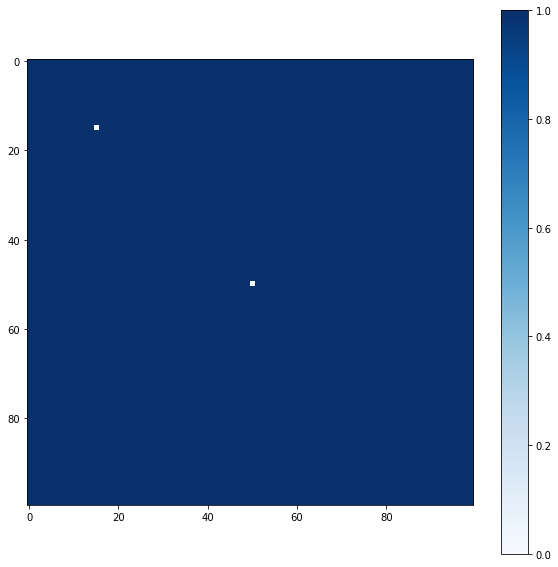

In [15]:
IS = min(successfull)
array = np.zeros([IS,IS])
from skimage import draw
rr, cc = draw.disk((50,50),11)
array[rr,cc] = 1
rr, cc = draw.rectangle((10,10),(20,20))
array[rr,cc] = 1
plt.figure(figsize=(10,10))
plt.imshow(array)
x0, y0 = 15, 15
x1,y1 = 50,50
from skimage import filters


mask = np.zeros([3,*array.shape])
mask[0, x0, y0] = 1
mask[1, x1, y1] = 1
mask[2] = 1 - (mask[0] + mask[1])


# mask = filters.gaussian(mask, sigma=5)
# mask /= mask.max()
mask_image = np.copy(mask)
# print(mask.max(), mask.min())
# mask_image[mask_image < 0.5] = np.nan
# plt.imshow(mask_image[0], alpha=.5, cmap='Reds')
# plt.imshow(mask_image[1], alpha=.5, cmap='Greens')
plt.imshow(mask_image[2], alpha=1, cmap='Blues')
plt.colorbar()

In [16]:
model = U_net([IS,IS], 1e-1)
optimizer = torch.optim.SGD(model.parameters(), lr=model.learning_rate)
model.summarize()

c:\ProgramData\Anaconda3\envs\dl\lib\site-packages\IPython\core\interactiveshell.py:3397: LightningDeprecationWarning: The `LightningModule.summarize` method is deprecated in v1.5 and will be removed in v1.7. Use `pytorch_lightning.utilities.model_summary.summarize` instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


  | Name            | Type    | Params | In sizes         | Out sizes       
----------------------------------------------------------------------------------
0 | enc_1           | Encoder | 846    | [1, 1, 100, 100] | [1, 9, 52, 52]  
1 | enc_2           | Encoder | 4.4 K  | [1, 9, 52, 52]   | [1, 18, 28, 28] 
2 | enc_3           | Encoder | 17.6 K | [1, 18, 28, 28]  | [1, 36, 16, 16] 
3 | dec_3           | Decoder | 8.8 K  | [1, 36, 16, 16]  | [1, 18, 28, 28] 
4 | dec_2           | Decoder | 2.2 K  | [1, 18, 28, 28]  | [1, 9, 52, 52]  
5 | dec_1           | Decoder | 336    | [1, 9, 52, 52]   | [1, 3, 100, 100]
6 | output_function | Softmax | 0      | [1, 3, 100, 100] | [1, 3, 100, 100]
----------------------------------------------------------------------------------
34.3 K    Trainable params
0         Non-trainable params
34.3 K    Total params
0.137     Total estimated model params size (MB)

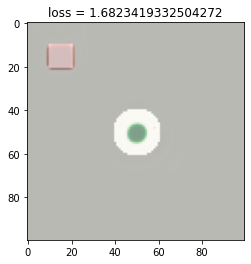

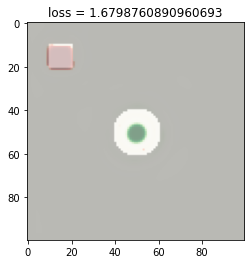

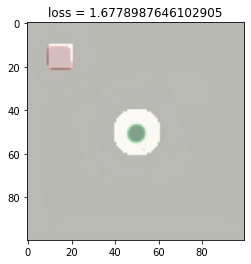

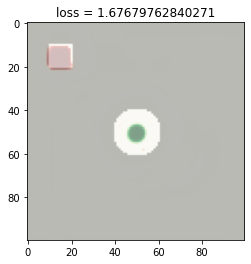

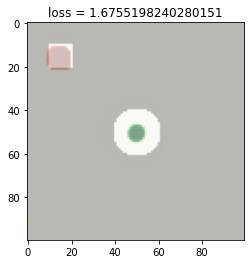

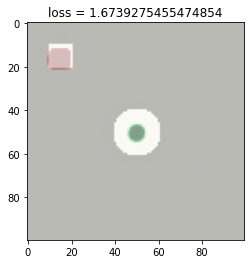

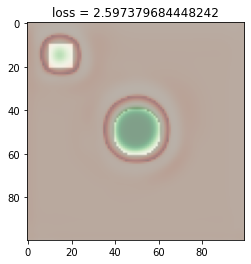

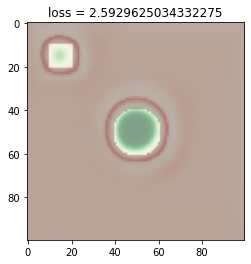

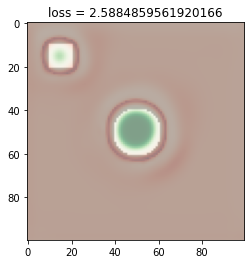

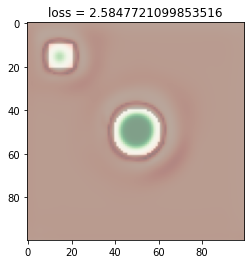

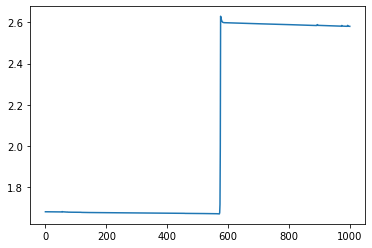

In [19]:
# optimizer.lr = 1e-2
model.cuda()
model.train()
losses = []
sublosses = []
for i in range(1000):
    x = torch.unsqueeze(torch.tensor(array), dim=0).float()
    x = torch.unsqueeze(x, dim=0).cuda()

    y = torch.unsqueeze(torch.tensor(mask).float(), dim=0).cuda()
    y_pred = model.forward(x)
    loss = model.loss(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    sublosses.append(loss.cpu().detach().numpy())
    if i % 100 == 0:
        y_pred = y_pred.cpu().detach().numpy()
        plt.imshow(array, cmap='gray')
        c1 = y_pred[0,0]
        c2 = y_pred[0,1]
        # c1[c1 < 0.9] = np.nan
        # c2[c2 < 0.9] = np.nan
        plt.imshow(c1, alpha=.5, cmap='Reds')
        plt.imshow(c2, alpha=.5, cmap='Greens')
        loss = float(loss.cpu().detach().numpy())
        plt.title(f'{loss = }')
        plt.show()

plt.plot(sublosses)
    

torch.Size([1, 1, 100, 100])
(9, 52, 52)


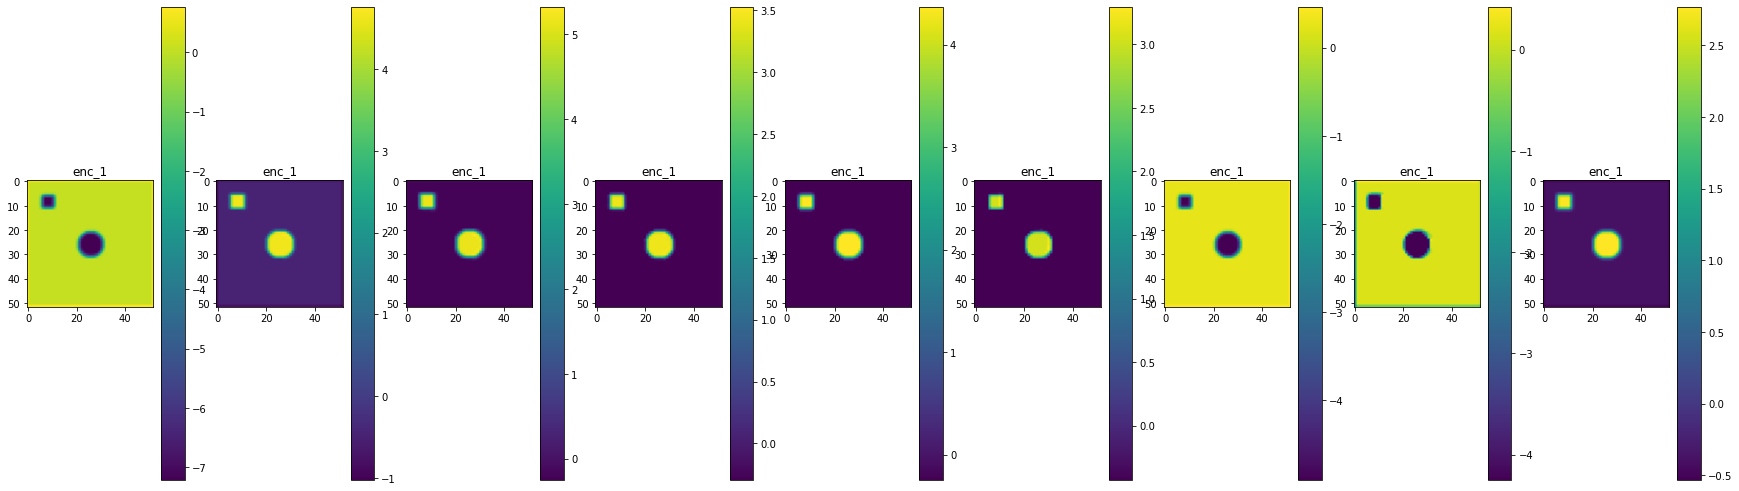

(18, 28, 28)


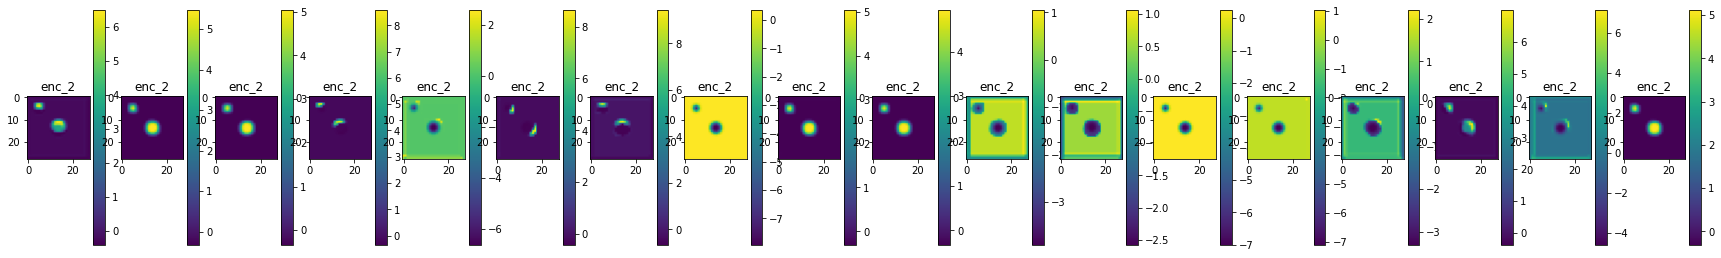

(36, 16, 16)


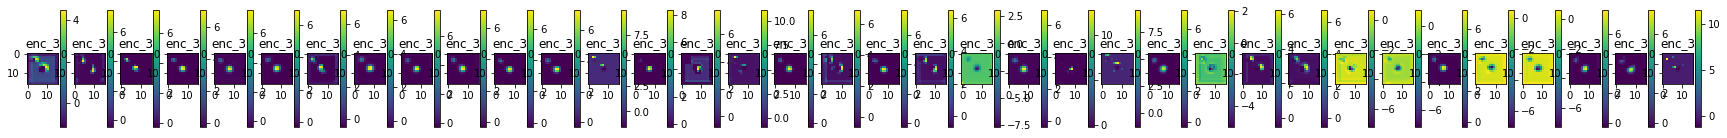

(18, 28, 28)


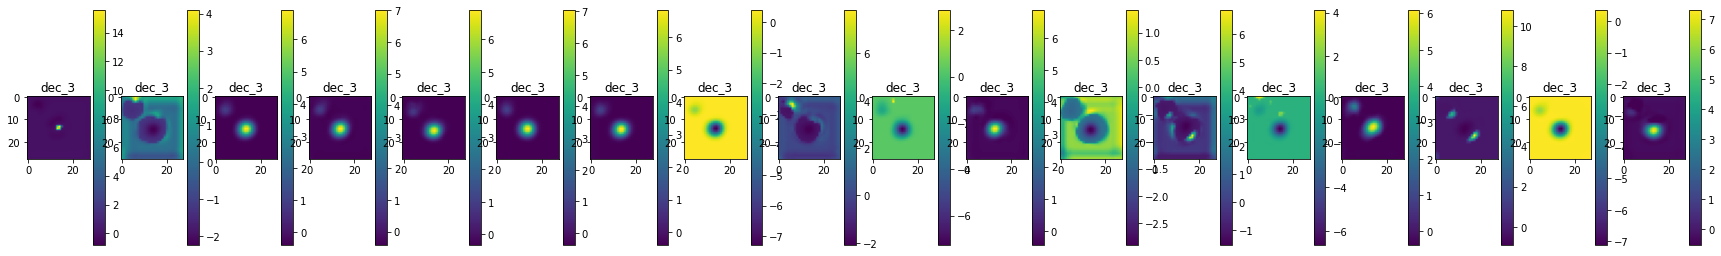

(9, 52, 52)


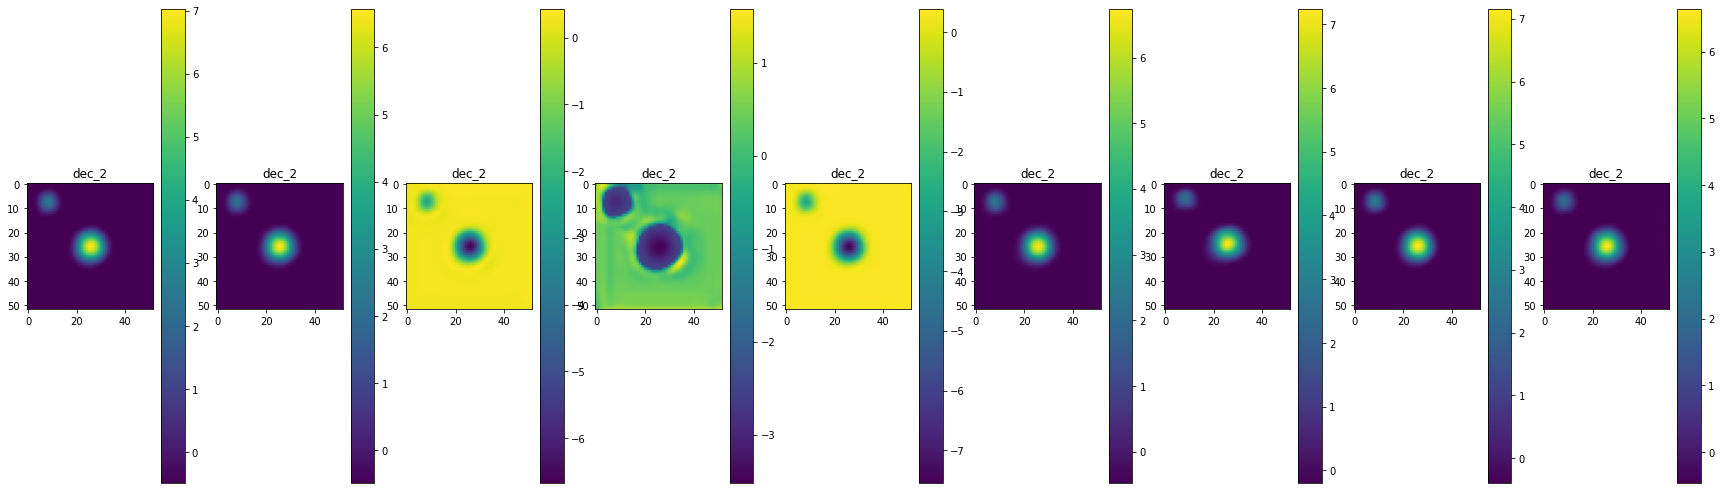

(3, 100, 100)


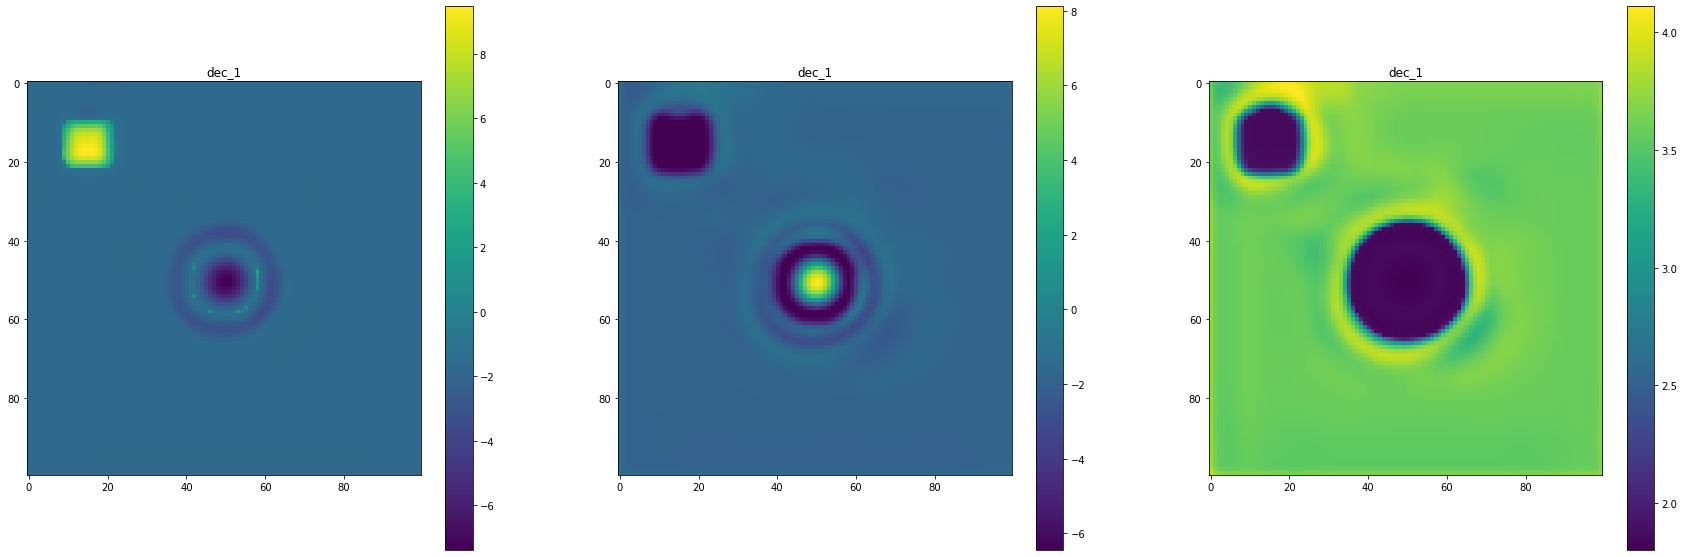

(3, 100, 100)


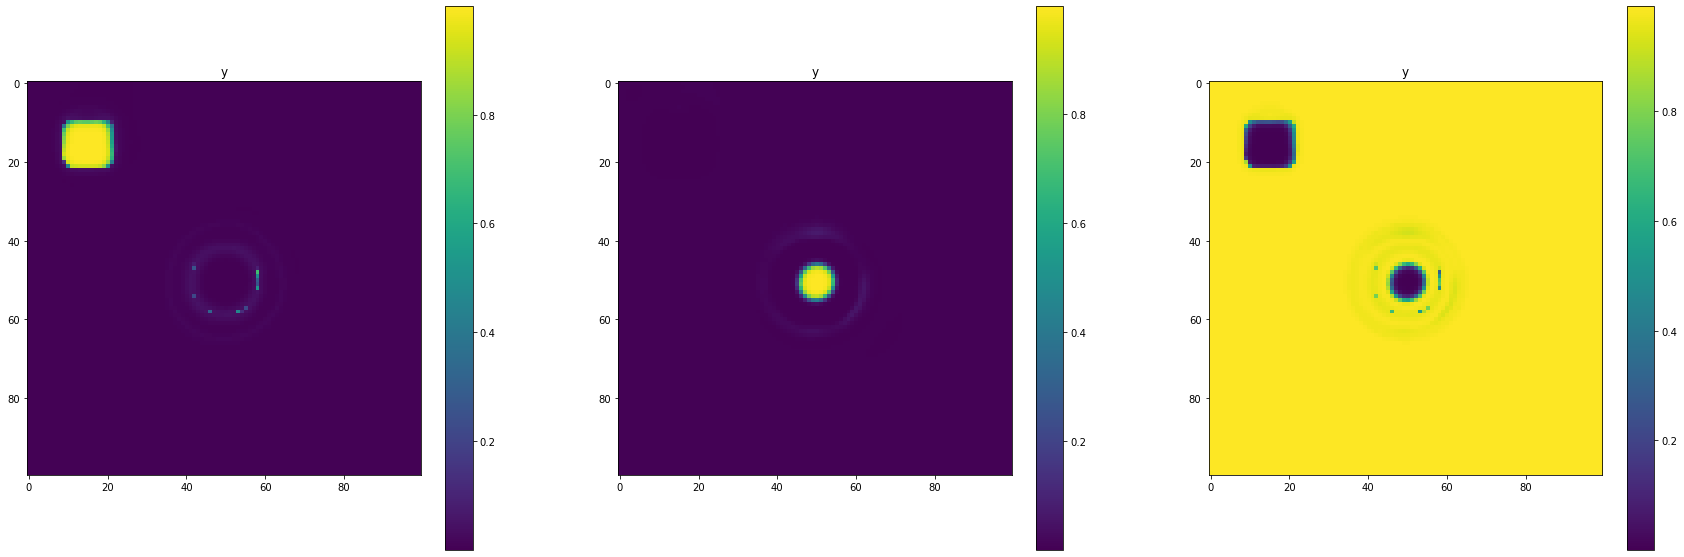

In [18]:
tensor = torch.unsqueeze(torch.tensor(array).float(), dim=0)
tensor = torch.unsqueeze(tensor, dim=0)
print(tensor.shape)
model.cpu()
model.eval()
model.debug_forward(tensor);

In [50]:
a = torch.zeros([1,2,3,3])
a[0,0,1,1] = 1
a[0,1,1,2] = 1

b = torch.tensor(np.copy(a))
b[a == 1] = 0.5
b = torch.nn.Softmax(dim=1)(b)
torch.nn.CrossEntropyLoss()(a, b)

tensor(0.6926)

In [63]:
a = torch.rand([1,3])*100
b = torch.tensor([[0,1,1]])
c = torch.nn.Softmax(dim=1)(a)
c

tensor([[9.9222e-01, 2.6454e-17, 7.7773e-03]])

In [60]:
a

tensor([[0.2773, 0.8424, 0.1725]])